In [1]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on 20190115

@author: zhangji

"""

%pylab inline
pylab.rcParams['figure.figsize'] = (25, 11)
fontsize = 40

import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d

from sympy import symbols, simplify, series, exp
from sympy.matrices import Matrix
from sympy.solvers import solve

from IPython.display import display, HTML
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import re
from scanf import scanf
import os
import glob
import importlib
from time import time

from codeStore import support_fun as spf
from src.support_class import *

rc('animation', html='html5')
PWD = os.getcwd()
font = {'size': 20}
matplotlib.rc('font', **font)
np.set_printoptions(linewidth=90, precision=5)


Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_Liu_Fig2a_results(dir_name):
    t_dir = os.path.join(PWD, dir_name)
    txt_names = glob.glob('./%s/*.txt' % dir_name)

    psi2 = []
    psi3 = []
    psi61 = []
    psi62 = []
    ph = []
    zf = []
    uz = []
    for txt_name in txt_names:
        with open(txt_name, 'r') as ftxt:
            FILE_DATA = ftxt.read()

        text_headle = 'Translation, helix forces and torques \['
        temp1 = spf.read_array(text_headle, FILE_DATA, array_length=6)
        psi2.append(temp1[2])
        psi61.append(temp1[5])

        text_headle = 'Rotation, helix forces and torques \['
        temp1 = spf.read_array(text_headle, FILE_DATA, array_length=6)
        psi62.append(temp1[2])
        psi3.append(temp1[5])

        text_headle = 'helix pitch: '
        temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
        ph.append(temp1)

        # below is our definition of zf 
#         text_headle = 'geometry zoom factor is '
#         temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
#         if np.isclose(temp1, 1):
#             temp1 = 0
#         zf.append(temp1)

        # below is Liu Bin's definition of zf
        text_headle = 'geometry zoom factor is '
        temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
        t_match = re.search('helix radius: \d+(\.\d+)? and \d+(\.\d+)?', FILE_DATA)
        rh1, rh2 = scanf('helix radius: %f and %f', FILE_DATA[t_match.start():t_match.end()])
        if np.isclose(temp1, 1):
            temp1 = 0
        temp1 = temp1 * (rh1 + rh2) / rh1
        zf.append(temp1)
        
        text_headle = 'Norm forward helix velocity is '
        temp1 = spf.read_array(text_headle, FILE_DATA, array_length=1)
        uz.append(temp1)

    data1 = pd.DataFrame({'ph':    np.hstack(ph), 
                          'zf':    np.hstack(zf), 
                          'psi2':  np.hstack(psi2), 
                          'psi3':  np.hstack(psi3), 
                          'psi61': np.hstack(psi61), 
                          'psi62': np.hstack(psi62),
                          'uz':    np.hstack(uz), })\
            .pivot_table(columns=['zf'])

    psi2 = data1.loc['psi2']
    psi3 = data1.loc['psi3']
    psi61 = data1.loc['psi61']
    psi62 = data1.loc['psi62']
    uz = data1.loc['uz']
    return psi2, psi3, psi61, psi62, uz


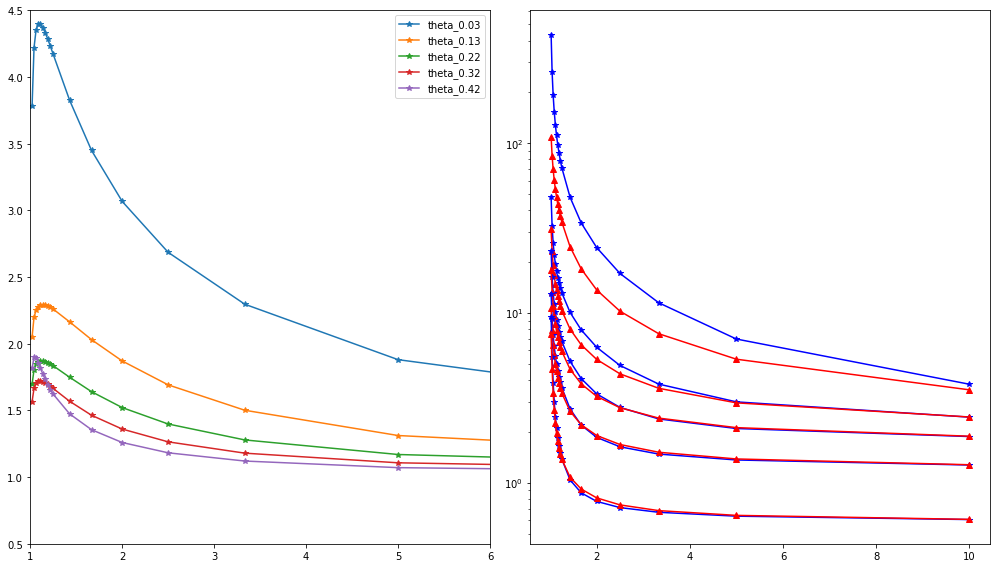

In [11]:
job_name_list = ['theta_0.03', 'theta_0.13', 'theta_0.22', 'theta_0.32', 'theta_0.42']
m_psi_list = []
for job_name in job_name_list:
    dir_name = 'compare_Liu/mFig_2_a/' + job_name
    m_psi_list.append(read_Liu_Fig2a_results(dir_name))

fig = plt.figure(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for t_psi, tlabel in zip(m_psi_list, job_name_list):
    tu = -t_psi[3] / t_psi[0]
    tu = tu / tu[0]
    ax1.plot(1 / tu.index, tu.values, '-*', label=tlabel)
    # ax1.plot(1 / tu.index, t_psi[4] / t_psi[4][0], '-*', label=t_label)
    ax1.set_xlim(1, 6)
    ax1.set_ylim(0.5, 4.5)
    ax1.legend()
    ax2.semilogy(1 / tu.index, np.abs(t_psi[2]), '-*b')
    ax2.semilogy(1 / tu.index, np.abs(t_psi[3]), '-^r')
    plt.tight_layout()

y = 407.079653 + 1983.583919 * x in range (0.12623999999999999, 0.81386999999999998)


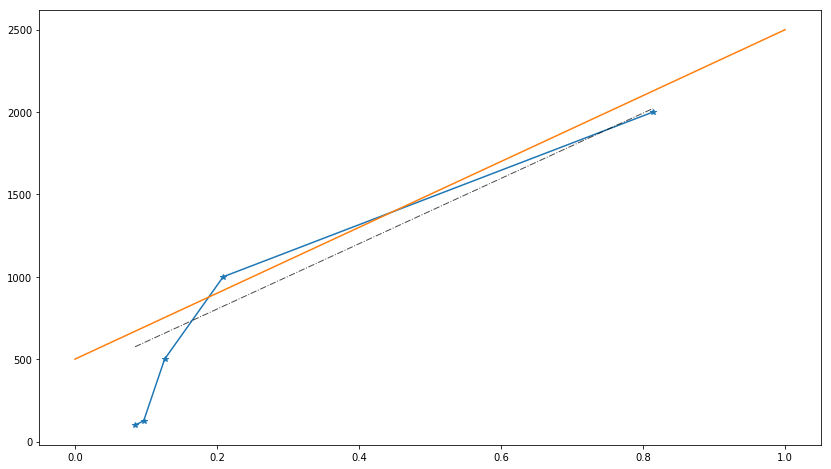

In [4]:
fig = plt.figure(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot([0.81387,  0.2087 ,  0.12624,  0.09674,  0.08461], 
         [2000,     1000,     500,      125,      100], '-*')
spf.fit_line(ax1, np.array([0.81387,  0.2087 ,  0.12624,  0.09674,  0.08461]), np.array([2000,     1000,     500,      125,      100]),
             0.1, 1, extendline=True )
tx = np.linspace(0, 1)
ax1.plot(tx, 500+tx*2000)
